In [1]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [18]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
file_path = '/content/drive/My Drive/Pretoria/LiDA/quora_duplicate_questions.tsv'
dataset=pd.read_csv(file_path, delimiter='\t',nrows=164000)

In [5]:
dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
dataset.shape

(164000, 6)

In [8]:
model = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')
embeddings = model.encode(dataset['question1'].tolist(), convert_to_tensor=True)

embeddings_tensor = embeddings.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
train_size = 150000
val_size = 14000

train_embeddings = embeddings_tensor[:train_size]
val_embeddings = embeddings_tensor[train_size:train_size+val_size]

In [15]:
def add_gaussian_noise(embeddings, mean=0.0, std=0.1):
    noise = torch.randn_like(embeddings) * std + mean
    noisy_embeddings = embeddings + noise
    return noisy_embeddings

noisy_train_embeddings = add_gaussian_noise(train_embeddings)
noisy_val_embeddings = add_gaussian_noise(val_embeddings)

In [19]:
class EmbeddingDataset(Dataset):
    def __init__(self, noisy_embeddings, original_embeddings):
        self.noisy_embeddings = noisy_embeddings
        self.original_embeddings = original_embeddings

    def __len__(self):
        return self.noisy_embeddings.size(0)

    def __getitem__(self, idx):
        return self.noisy_embeddings[idx], self.original_embeddings[idx]

In [24]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, learning_rate):
        super(DenoisingAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, embedding_dim)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def add_noise(self, x, noise_frac):
        noise = torch.randn_like(x) * noise_frac
        noisy_x = x + noise
        return noisy_x

    def train_step(self, x, y, noise_frac=0.5):
        self.train()
        self.optimizer.zero_grad()
        noisy_x = self.add_noise(x, noise_frac)
        reconstructions = self(noisy_x)
        loss = self.loss_fn(reconstructions, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def test_step(self, x, y):
        self.eval()
        with torch.no_grad():
            reconstructions = self(x)
            loss = self.loss_fn(reconstructions, y)
        return loss.item()


In [25]:
embedding_dim = 768
hidden_dim = 300
learning_rate = 0.001
batch_size = 32
epochs = 20


train_dataset = EmbeddingDataset(noisy_train_embeddings, train_embeddings)
val_dataset = EmbeddingDataset(noisy_val_embeddings, val_embeddings)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



denoising_autoencoder = DenoisingAutoEncoder(embedding_dim, hidden_dim, learning_rate).to(device)


In [27]:
for epoch in range(epochs):
    denoising_autoencoder.train()
    total_train_loss = 0
    for noisy, original in train_dataloader:
        noisy = noisy.to(device)
        original = original.to(device)
        loss = denoising_autoencoder.train_step(noisy, original, noise_frac=0.5)
        total_train_loss += loss

    avg_train_loss = total_train_loss / len(train_dataloader)

    denoising_autoencoder.eval()
    total_val_loss = 0
    for noisy, original in val_dataloader:
        noisy = noisy.to(device)
        original = original.to(device)
        loss = denoising_autoencoder.test_step(noisy, original)
        total_val_loss += loss

    avg_val_loss = total_val_loss / len(val_dataloader)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Epoch [1/20], Train Loss: 0.0662, Val Loss: 0.0401
Epoch [2/20], Train Loss: 0.0582, Val Loss: 0.0395
Epoch [3/20], Train Loss: 0.0572, Val Loss: 0.0397
Epoch [4/20], Train Loss: 0.0566, Val Loss: 0.0396
Epoch [5/20], Train Loss: 0.0563, Val Loss: 0.0390
Epoch [6/20], Train Loss: 0.0561, Val Loss: 0.0391
Epoch [7/20], Train Loss: 0.0559, Val Loss: 0.0392
Epoch [8/20], Train Loss: 0.0559, Val Loss: 0.0390
Epoch [9/20], Train Loss: 0.0558, Val Loss: 0.0393
Epoch [10/20], Train Loss: 0.0557, Val Loss: 0.0391
Epoch [11/20], Train Loss: 0.0557, Val Loss: 0.0395
Epoch [12/20], Train Loss: 0.0557, Val Loss: 0.0391
Epoch [13/20], Train Loss: 0.0556, Val Loss: 0.0390
Epoch [14/20], Train Loss: 0.0556, Val Loss: 0.0395
Epoch [15/20], Train Loss: 0.0556, Val Loss: 0.0392
Epoch [16/20], Train Loss: 0.0556, Val Loss: 0.0396
Epoch [17/20], Train Loss: 0.0556, Val Loss: 0.0390
Epoch [18/20], Train Loss: 0.0556, Val Loss: 0.0392
Epoch [19/20], Train Loss: 0.0555, Val Loss: 0.0394
Epoch [20/20], Train 

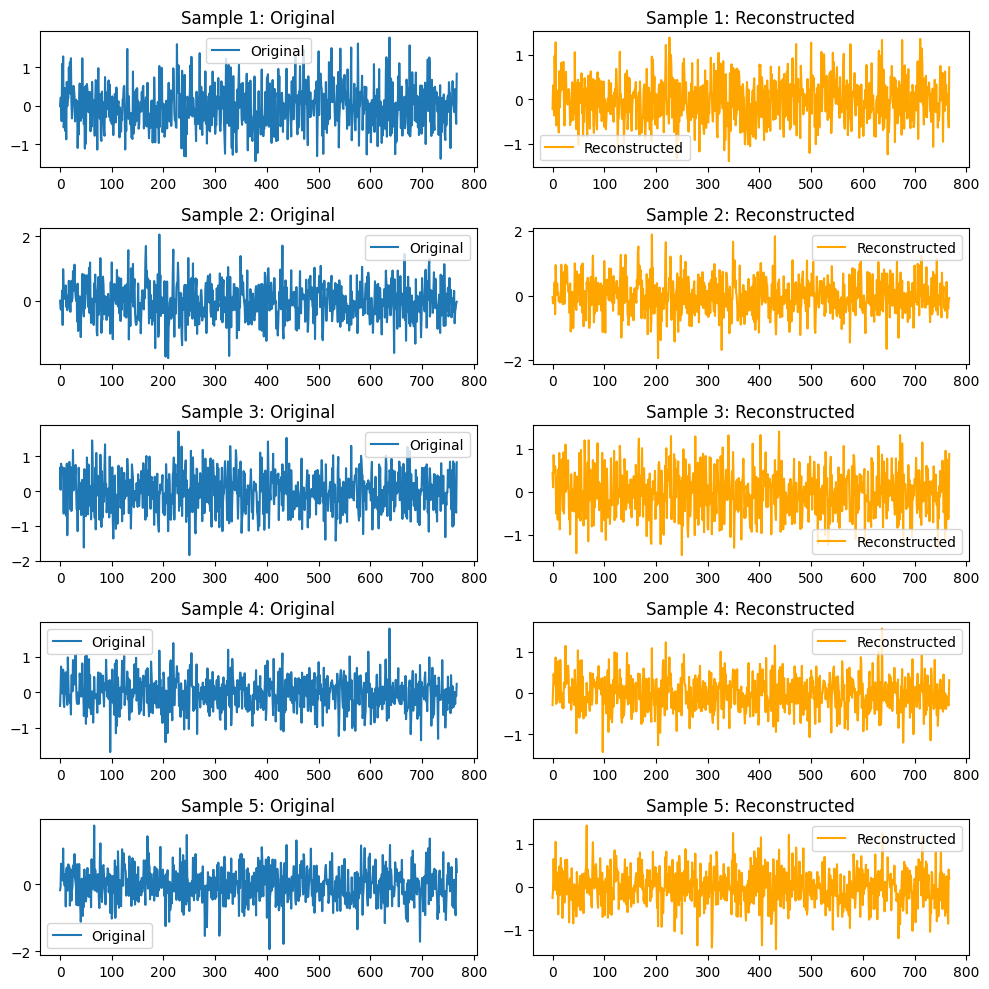

In [30]:
test_data = dataset.sample(n=100)
test_questions = test_data['question1']

encoded_questions = model.encode(test_questions.tolist(), convert_to_tensor=True)

test_data_tensor = encoded_questions.to(device)

denoising_autoencoder.eval()
with torch.no_grad():
    reconstructed_data = denoising_autoencoder(test_data_tensor)

reconstructed_data = reconstructed_data.cpu().detach().numpy()

num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2*num_samples))

for i in range(num_samples):
    original_sample = test_data_tensor[i].cpu().detach().numpy()
    reconstructed_sample = reconstructed_data[i]

    axes[i, 0].plot(original_sample, label='Original')
    axes[i, 0].set_title(f'Sample {i+1}: Original')
    axes[i, 0].legend()

    axes[i, 1].plot(reconstructed_sample, label='Reconstructed', color='orange')
    axes[i, 1].set_title(f'Sample {i+1}: Reconstructed')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [31]:
reconstruction_loss_fn = nn.MSELoss()
mse_loss = reconstruction_loss_fn(torch.tensor(reconstructed_data), test_data_tensor.cpu()).item()
rmse_loss = torch.sqrt(torch.tensor(mse_loss))
mae_loss_fn = nn.L1Loss()
mae_loss = mae_loss_fn(torch.tensor(reconstructed_data), test_data_tensor.cpu()).item()

print(f"Mean Squared Error (MSE): {mse_loss}")
print(f"Root Mean Squared Error (RMSE): {rmse_loss}")
print(f"Mean Absolute Error (MAE): {mae_loss}")


Mean Squared Error (MSE): 0.03696908801794052
Root Mean Squared Error (RMSE): 0.19227346777915955
Mean Absolute Error (MAE): 0.15222172439098358


In [33]:
torch.save(denoising_autoencoder.state_dict(), 'LiDA_DAE.pth')